# Arquivos Necessários

In [ ]:
import pandas as pd
import numpy as np
import random
import time
import pickle as pkl
import itertools as it
from tqdm.notebook import trange, tqdm
import sys, warnings
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.metrics import jaccard_score
import seaborn as sns
import matplotlib.pyplot as plt
#!pip3 install fastplot
#import fastplot
import networkx as nx
!pip3 install python-igraph
import igraph as ig
import math
from itertools import chain
random.seed(2022)
import joblib
from tqdm import tqdm
import re
import hashlib
import psycopg2
from psycopg2 import extras as ex
from datetime import datetime, timezone
import time
import pytz
from time import mktime
from datetime import datetime
import time

# Pacotes para pre-processamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Pacotes para treino, teste e validação
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as multiple_scores
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

# Algoritmos de Classificação
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 13.7 MB/s eta 0:00:00


In [ ]:
# Access my drive to load the dataset
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# Determine the path of dataset
PROJECT_PATH = '<pĺace-holder>'
DATA_PATH = PROJECT_PATH + 'streamspot-data/'
print("\nDATA FOLDER: ")
!ls -lah $DATA_PATH


DATA FOLDER: 
total 6.6G
-rw------- 1 root root 2.2G Jan 31 16:50 'Cópia de all.tsv'
-rw------- 1 root root 2.2G Jan 31 16:50 'Cópia de all_with_headers_full.tsv'
-rw------- 1 root root 2.2G Jan 31 16:50 'Cópia de all_with_headers.tsv'
-rw------- 1 root root 151M Feb 15 23:17  right_dataset_manipulation.zip


In [ ]:
CONSOLIDATED = 'consolidated/'
!mkdir $CONSOLIDATED

FILTERED_CONSOLIDATED = 'filtered_consolidated/'
!mkdir $FILTERED_CONSOLIDATED

NOISE_CONSOLIDATED = 'noise_consolidated/'
!mkdir $NOISE_CONSOLIDATED

BASE = 'base/'
!mkdir $BASE

CONCAT = 'concat/'
!mkdir $CONCAT

BACKBONE = 'backbone/'
!mkdir $BACKBONE

FILTERED = 'filtered/'
!mkdir $FILTERED

NOISE = 'noise/'
!mkdir $NOISE

ANOM_GML = 'anom_gml/'
!mkdir $ANOM_GML

In [ ]:
# !unzip $DATA_PATH/scenario0_allgraphs.zip -d $BASE
# !unzip $DATA_PATH/scenario1_allgraphs.zip -d $BASE
# !unzip $DATA_PATH/scenario2_allgraphs.zip -d $BASE
# !unzip $DATA_PATH/scenario3_allgraphs.zip -d $BASE
# !unzip $DATA_PATH/scenario4_allgraphs.zip -d $BASE
# !unzip $DATA_PATH/scenario5_allgraphs.zip -d $BASE
#
# !unzip $DATA_ORIGINAL/cenarios_disparity_filter_analisados/filtered_consolidated.zip
# !unzip $DATA_ORIGINAL/cenarios_disparity_filter_analisados/noise_consolidated.zip
# !unzip $DATA_ORIGINAL/cenarios_disparity_filter_analisados/consolidated.zip
# !unzip $DATA_ORIGINAL/cenarios_disparity_filter_analisados/concat.zip
# !unzip $DATA_ORIGINAL/cenarios_disparity_filter_analisados/backbone.zip
# !unzip $DATA_ORIGINAL/cenarios_disparity_filter_analisados/filtered.zip
# !unzip $DATA_ORIGINAL/cenarios_disparity_filter_analisados/noise.zip
# !unzip $DATA_ORIGINAL/cenarios_disparity_filter_analisados/anom_gml.zip
!unzip -o $DATA_PATH/right_dataset_manipulation.zip

# Funções

In [ ]:
def disparity_filter(table, undirected = True):
    table_sum = table.groupby(table["src"]).sum().reset_index()
    table_deg = table.groupby(table["src"]).count()["trg"].reset_index()
    table = table.merge(table_sum, on = "src", how = "left", suffixes = ("", "_sum"))
    table = table.merge(table_deg, on = "src", how = "left", suffixes = ("", "_count"))
    table["score"] = 1.0 - ((1.0 - (table["nij"] / table["nij_sum"])) ** (table["trg_count"] - 1))
    if undirected:
        table["edge"] = table.apply(lambda x: "%s-%s" % (min(x["src"], x["trg"]), max(x["src"], x["trg"])), axis = 1)
        table_maxscore = table.groupby(by = "edge")["score"].max().reset_index()
        table = table.merge(table_maxscore, on = "edge", suffixes = ("_min", ""))
        table = table.drop_duplicates(subset = ["edge"])
        table = table.drop("edge", 1)
        table = table.drop("score_min", 1)
        #   table = table.drop("variance_max", 1)
    return table[["src", "trg", "nij", "score"]]

def read(filename, column_of_interest, triangular_input = False, consider_self_loops = False, undirected = True, drop_zeroes = False):
    """Reads a field separated input file into the internal backboning format (a Pandas Dataframe).
    The input file should have three or more columns (default separator: tab).
    The input file must have a one line header with the column names.
    There must be two columns called 'src' and 'trg', indicating the origin and destination of the interaction.
    All other columns must contain integer or floats, indicating the edge weight.
    In case of undirected network, the edges have to be present in both directions with the same weights, or set triangular_input to True.

    Args:
    filename (str): The path to the file containing the edges.
    column_of_interest (str): The column name identifying the weight that will be used for the backboning.

    KWArgs:
    triangular_input (bool): Is the network undirected and are the edges present only in one direction? default: False
    consider_self_loops (bool): Do you want to consider self loops when calculating the backbone? default: True
    undirected (bool): Is the network undirected? default: False
    drop_zeroes (bool): Do you want to keep zero weighted connections in the network? Important: it affects methods based on degree, like disparity_filter. default: False
    sep (char): The field separator of the inout file. default: tab

    Returns:
    The parsed network data, the number of nodes in the network and the number of edges.
    """
    table = pd.read_csv(filename)
    table = table[["src", "trg", column_of_interest]]
    table.rename(columns = {column_of_interest: "nij"}, inplace = True)
    if drop_zeroes:
        table = table[table["nij"] > 0]
    if not consider_self_loops:
        table = table[table["src"] != table["trg"]]
    if triangular_input:
        table2 = table.copy()
        table2["new_src"] = table["trg"]
        table2["new_trg"] = table["src"]
        table2.drop("src", 1, inplace = True)
        table2.drop("trg", 1, inplace = True)
        table2 = table2.rename(columns = {"new_src": "src", "new_trg": "trg"})
        table = pd.concat([table, table2], axis = 0)
        table = table.drop_duplicates(subset = ["src", "trg"])
    original_nodes = len(set(table["src"]) | set(table["trg"]))
    original_edges = table.shape[0]
    if undirected:
        return table, original_nodes, original_edges / 2
    else:
        return table, original_nodes, original_edges

# Jaccard similarity
def compute_sim(task_i, task_j):
  intersection_size = len(task_i.intersection(task_j))
  union_size = len(task_i.union(task_j))
  return intersection_size / union_size

# Overlap similarity
def compute_sim_overlap(task_i, task_j):
  intersection_size = len(task_i.intersection(task_j))
  min_size = min(len(task_i), len(task_j))
  return intersection_size / min_size

def compute_sim_carlos(task_i, task_j):
  intersection_size = len(task_i.intersection(task_j))
  #...
  return intersection_size / len(task_j)

def compute_sim_carlos2(task_i, task_j):
  #TODO: task_j precisa ser o fluxo, e não todo o experimento a ser comparado
  return


def compute_metrics(path, scenario):
  G = []
  average_nodes_number = 0
  average_edges_number = 0
  average_weights_number = 0
  for i in range(100 * scenario,100 * (scenario + 1)):
    match path:
      case 'consolidated/':
        filename = 'scenario' + str(scenario) + '_graph' + str(i) + '_consolidated'
      case 'filtered_consolidated/':
        filename = 'Backbone_filtered_consolidated' + str(i) + '.edgelist'
      case 'noise_consolidated/':
        filename = 'Backbone_noise_consolidated' + str(i) + '.edgelist'
      case 'concat/':
        filename = 'scenario' + str(scenario) + '_graph' + str(i) + '_concat'
      case 'filtered/':
        filename = 'Backbone_filtered' + str(i) + '.edgelist'
      case 'noise/':
        filename = 'Backbone_noise' + str(i) + '.edgelist'
      case 'backbone/':
        filename = 'Backbone' + str(i) + '.edgelist'
      case _:
        print('Unknown path!')
        sys.exit(-1)
    df = pd.read_csv(path + filename)
    df.rename(columns = {'edge-type':'edgetype'}, inplace = True)
    df['isAnom'] = False
    match path:
      case 'consolidated/' | 'filtered_consolidated/' | 'noise_consolidated/':
        G.append(
            nx.from_pandas_edgelist(
              df,
              source='src-type',
              target='trg-type',
              edge_attr=['edgetype', 'nij', 'isAnom'],
              create_using=nx.MultiDiGraph()
            )
        )
      case 'concat/' | 'filtered/' | 'noise/':
        G.append(
            nx.from_pandas_edgelist(
              df,
              source='src',
              target='trg',
              edge_attr=['edgetype', 'nij', 'isAnom'],
              create_using=nx.MultiDiGraph()
            )
        )
      case 'backbone/':
        df.rename(columns = {'src-type':'srctype'}, inplace = True)
        df.rename(columns = {'trg-type':'trgtype'}, inplace = True)
        G.append(
            nx.from_pandas_edgelist(
              df,
              source='src',
              target='trg',
              edge_attr=['edgetype', 'nij', 'srctype', 'trgtype', 'isAnom'],
              create_using=nx.MultiDiGraph()
            )
        )

    average_nodes_number += G[i % 100].number_of_nodes()
    average_edges_number += G[i % 100].number_of_edges()
    average_weights_number += G[i % 100].size(weight='nij')


  average_nodes_number /= 100
  average_edges_number /= 100
  average_weights_number /= 100

  sd_nodes = 0
  sd_edges = 0
  sd_weights = 0
  for i in range(0,100):
    sd_nodes += pow(G[i].number_of_nodes() - average_nodes_number, 2) / 100
    sd_edges += pow(G[i].number_of_edges() - average_edges_number, 2) / 100
    sd_weights += pow(G[i].size(weight='nij') - average_weights_number, 2) / 100

  sd_nodes = math.sqrt(sd_nodes)
  sd_edges = math.sqrt(sd_edges)
  sd_weights = math.sqrt(sd_weights)

  return G, [average_nodes_number, average_edges_number, average_weights_number], [sd_nodes, sd_edges, sd_weights]

def print_nodes_path_freq(graph, number_of_edges):
  set_node_edge_path = []
  counter_total = 0
  counter_selective = 0
  for node1 in graph.nodes:
    for node2 in graph.nodes:
      if node1 != node2 and nx.has_path(graph, node1, node2):
        for path in nx.all_simple_edge_paths(graph, node1, node2):
          if(len(path) == number_of_edges):
            set_node_edge_path.append([])
            for p in path:
              edge = graph[p[0]][p[1]][p[2]]
              aux = tuple(zip(edge['srctype'], edge['trgtype'], edge['edgetype'], str(edge['nij'])))
              set_node_edge_path[counter_selective].append(aux)

            counter_selective = counter_selective + 1
          counter_total = counter_total + 1
  print(f'Paths that contains only {number_of_edges + 1} nodes: {counter_selective}')
  print(f'Total paths: {counter_total}')
  percentage = counter_selective / counter_total * 100
  print(f'Percentage of paths that contains {number_of_edges + 1} nodes: {percentage}')
  return set_node_edge_path

#Função auxiliar para obter um dado score de um modelo
def get_score(y_test, y_pred, metric):
  precision,recall,fscore,support=multiple_scores(y_test, y_pred, average='macro')
  accuracy = metrics.accuracy_score(y_test, y_pred)
  dict_scores = dict(zip(['precision', 'recall', 'fscore', 'accuracy', 'support'], [precision, recall, fscore, accuracy, support]))
  return dict_scores[metric]


# Classifier

## Similaridade benignos e ataque

In [ ]:
list_result_filtered = []
counter = 0
for l in it.chain(range(0, 300, 100), range(400, 600, 100)):
  for i in range(20 + l, 100 + l):
    filename = 'Backbone_filtered_consolidated' + str(i) + '.edgelist'
    df_i_filtered = pd.read_csv(FILTERED_CONSOLIDATED + filename)
    set_task_i_filtered = set(tuple(zip(df_i_filtered['src-type'],df_i_filtered['trg-type'],df_i_filtered['edge-type'])))
    for k in it.chain(range(0, 300, 100), range(400, 600, 100)):
      for j in range(0 + k, 20 + k):
        filename = 'Backbone_filtered_consolidated' + str(j) + '.edgelist'
        df_j_filtered = pd.read_csv(FILTERED_CONSOLIDATED + filename)
        set_task_j_filtered = set(tuple(zip(df_j_filtered['src-type'],df_j_filtered['trg-type'],df_j_filtered['edge-type'])))
        sim_filtered = compute_sim(set_task_i_filtered, set_task_j_filtered)
        list_result_filtered.append((i,j,sim_filtered))

df = pd.DataFrame(list_result_filtered, columns=['Task1', 'Task2', 'Similarity'])
filename_csv = 'similarity_backbone_benign_benign.csv'
df.to_csv(filename_csv, index = False)



In [ ]:
list_result_filtered = []
counter = 0
for i in range(300, 400):
  filename = 'Backbone_filtered_consolidated' + str(i) + '.edgelist'
  df_i_filtered = pd.read_csv(FILTERED_CONSOLIDATED + filename)
  set_task_i_filtered = set(tuple(zip(df_i_filtered['src-type'],df_i_filtered['trg-type'],df_i_filtered['edge-type'])))
  for k in it.chain(range(0, 300, 100), range(400, 600, 100)):
    for j in range(0 + k, 20 + k):
      filename = 'Backbone_filtered_consolidated' + str(j) + '.edgelist'
      df_j_filtered = pd.read_csv(FILTERED_CONSOLIDATED + filename)
      set_task_j_filtered = set(tuple(zip(df_j_filtered['src-type'],df_j_filtered['trg-type'],df_j_filtered['edge-type'])))
      sim_filtered = compute_sim(set_task_i_filtered, set_task_j_filtered)
      list_result_filtered.append((i,j,sim_filtered))

df = pd.DataFrame(list_result_filtered, columns=['Task1', 'Task2', 'Similarity'])
filename_csv = 'similarity_backbone_benign_attack.csv'
df.to_csv(filename_csv, index = False)



## Cálculo momentos

In [ ]:
df_benign_benign = pd.read_csv('similarity_backbone_benign_benign.csv')
df_benign_attack = pd.read_csv('similarity_backbone_benign_attack.csv')

In [ ]:
list_result = []
for k in it.chain(range(0, 300, 100), range(400, 600, 100)):
  for i in range(20 + k, 80 + k):
    row = df_benign_benign[df_benign_benign['Task1'] == i]
    M1 = row['Similarity'].mean()
    M2 = row['Similarity'].var()
    M3 = row['Similarity'].skew()
    M4 = row['Similarity'].kurtosis()
    list_result.append((i, M1,M2,M3,M4))
df_moment_benign_train = pd.DataFrame(list_result, columns=['Graph', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
df_moment_benign_train['isInlier'] = 1
df_moment_benign_train['isTest'] =  0

list_result = []
for k in it.chain(range(0, 300, 100), range(400, 600, 100)):
  for i in range(80 + k, 100 + k):
    row = df_benign_benign[df_benign_benign['Task1'] == i]
    M1 = row['Similarity'].mean()
    M2 = row['Similarity'].var()
    M3 = row['Similarity'].skew()
    M4 = row['Similarity'].kurtosis()
    list_result.append((i,M1,M2,M3,M4))
df_moment_benign_test = pd.DataFrame(list_result, columns=['Graph', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
df_moment_benign_test['isInlier'] = 1
df_moment_benign_test['isTest'] =  1


list_result = []
for i in range(300, 400):
    row = df_benign_attack[df_benign_attack['Task1'] == i]
    M1 = row['Similarity'].mean()
    M2 = row['Similarity'].var()
    M3 = row['Similarity'].skew()
    M4 = row['Similarity'].kurtosis()
    list_result.append((i,M1,M2,M3,M4))
df_moment_attack = pd.DataFrame(list_result, columns=['Graph', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
df_moment_attack['isInlier'] = -1
df_moment_attack['isTest'] = 1

df_moment = pd.concat([df_moment_benign_train, df_moment_benign_test, df_moment_attack])
df_moment.to_csv('backbone_moments.csv', index=False)

## Classifier model

In [ ]:
df = pd.read_csv('backbone_moments.csv')
df

,Graph,Mean,Variance,Skewness,Kurtosis,isInlier,isTest
0,20,0.838173,0.003326,0.596088,0.544901,1,0
1,21,0.921467,0.003172,-0.374689,-0.395011,1,0
2,22,0.921467,0.003172,-0.374689,-0.395011,1,0
3,23,0.875484,0.003977,-0.155056,-0.880843,1,0
4,24,0.911786,0.002134,-0.736762,2.169923,1,0
...,...,...,...,...,...,...,...
495,395,0.582951,0.001043,0.565150,0.932402,-1,1
496,396,0.555452,0.000680,0.626621,0.077925,-1,1
497,397,0.594657,0.002756,-0.693817,-0.379011,-1,1
498,398,0.582951,0.001043,0.565150,0.932402,-1,1


In [ ]:
df_train = df[df['isTest'] == 0].reset_index()
X_train = df_train[df_train.columns[2:-2]]
y_train = df_train[df_train.columns[-2]]

df_test = df[df['isTest'] == 1].reset_index()
X_test = df_test[df_test.columns[2:-2]]
y_test = df_test[df_test.columns[-2]]

In [ ]:
pipe_isolation = Pipeline([('clf', IsolationForest(random_state = 2024))])
pipe_ocsvm = Pipeline([('ocsvm', OneClassSVM())])
pipe_lof = Pipeline([('lof', LocalOutlierFactor(novelty=True))])


# Isolation Forest parameters
n_estimators_range = [5, 10, 25, 50, 100]
max_samples_range = [len(X_train) // 4, len(X_train) // 2, len(X_train)]
contamination_range = [0.1, 0.2, 0.3, 0.4, 0.5]
max_features_range = [1, 2, 3, 4]

# OCSVM parameters
gamma_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
nu_range = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]

# LOF parameters
contamination_range = [0.1, 0.2, 0.3, 0.4, 0.5]
n_neighbors_range = [2, 3, 4, 5, 6, 7, 10, 15, 20]
leaf_size_range = [5, 15, 20, 25, 30, 50]



# Montagem dos parâmetros em grid
# Atente-se a sintaxe:clf__XXXXX. Indica que é um parâmetro do classificador (clf)
grid_params_isolation = [{'clf__n_estimators': n_estimators_range, 'clf__max_samples': max_samples_range,
                          'clf__contamination': contamination_range, 'clf__max_features': max_features_range}]

grid_params_ocsvm = [{'ocsvm__gamma': gamma_range, 'ocsvm__nu': nu_range}]

grid_params_lof = [{'lof__contamination': contamination_range, 'lof__n_neighbors': n_neighbors_range,
                    'lof__leaf_size': leaf_size_range}]


performance_metric = 'f1'

grid_isolation = GridSearchCV(
    estimator = pipe_isolation,
    param_grid = grid_params_isolation,
    scoring = performance_metric,
    n_jobs = -1,
    cv = 5,
    refit = True,
    error_score = "raise"
)

grid_ocsvm = GridSearchCV(
    estimator = pipe_ocsvm,
    param_grid = grid_params_ocsvm,
    scoring = performance_metric,
    n_jobs = -1,
    cv = 5,
    refit = True
)

grid_lof = GridSearchCV(
    estimator = pipe_lof,
    param_grid = grid_params_lof,
    scoring = performance_metric,
    n_jobs = -1,
    cv = 5,
    refit = True
)

grid_list = [grid_isolation, grid_ocsvm, grid_lof]
#grid_list = [grid_isolation]
grid_dict = {0:'Isolation Forest', 1:'OCSVM', 2:'LOF'}

print('Analisando os modelos definidos...')
best_score = 0.0
best_clf = 0
best_gs = ''

for _id, gs in enumerate(grid_list):
  print(f'\nModelo: {grid_dict[_id]}')
  gs.fit(X_train.values, y_train)
  print(f'Melhores parâmetros {gs.best_params_}')
  y_pred = gs.predict(X_test.values)
  print(classification_report(y_test, y_pred, zero_division=1.0))
  tp, fn, fp, tn = metrics.confusion_matrix(y_test,y_pred).ravel()
  print(f'TP: {tp} | FN: {fn} | FP: {fp} | TN: {tn}')

  score = get_score(y_test, y_pred, 'fscore')
  print(f'Pontuação de F1-score do conjunto de teste para os melhores parâmetros: {score}')

  if(score > best_score):
    best_score = score
    best_gs = gs
    best_clf_id = _id

print(f'\nClassificador com o melhor desempenho no conjunto de teste: {grid_dict[best_clf_id]}')

file_name = 'melhorModelo_backbone.pkl'
joblib.dump(best_gs, file_name, compress=1)
print(f'\nSalvou {grid_dict[best_clf_id]} no arquivo: {file_name}')

Analisando os modelos definidos...

Modelo: Isolation Forest
Melhores parâmetros {'clf__contamination': 0.1, 'clf__max_features': 4, 'clf__max_samples': 75, 'clf__n_estimators': 5}
              precision    recall  f1-score   support

          -1       0.89      1.00      0.94       100
           1       1.00      0.88      0.94       100

    accuracy                           0.94       200
   macro avg       0.95      0.94      0.94       200
weighted avg       0.95      0.94      0.94       200

TP: 100 | FN: 0 | FP: 12 | TN: 88
Pontuação de F1-score do conjunto de teste para os melhores parâmetros: 0.939783219590526

Modelo: OCSVM
Melhores parâmetros {'ocsvm__gamma': 0.001, 'ocsvm__nu': 0.01}
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       100
           1       0.49      0.97      0.65       100

    accuracy                           0.48       200
   macro avg       0.25      0.48      0.33       200
weighted avg      

In [ ]:
#Carrega o modelo - Não só o modelo, mas todo o pipeline que foi aplicado.
file_name_backbone = 'melhorModelo_backbone.pkl'
model_backbone = joblib.load(file_name)
model_backbone.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__clf', 'estimator__clf__bootstrap', 'estimator__clf__contamination', 'estimator__clf__max_features', 'estimator__clf__max_samples', 'estimator__clf__n_estimators', 'estimator__clf__n_jobs', 'estimator__clf__random_state', 'estimator__clf__verbose', 'estimator__clf__warm_start', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [ ]:
#Caso queira fazer algum teste futuro
y_pred = model_backbone.predict(X_test.values)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.89      1.00      0.94       100
           1       1.00      0.88      0.94       100

    accuracy                           0.94       200
   macro avg       0.95      0.94      0.94       200
weighted avg       0.95      0.94      0.94       200



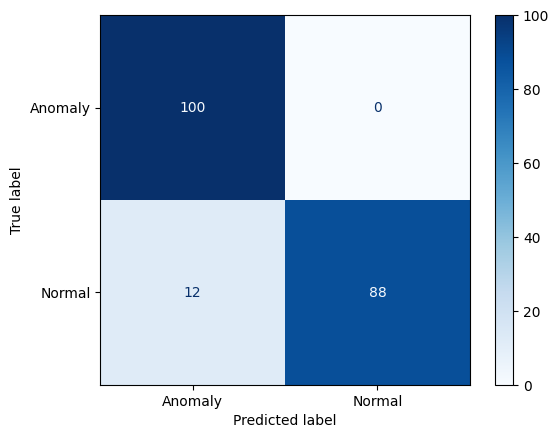

In [ ]:
y_pred_plot = y_pred.copy()
y_pred_plot[y_pred_plot == -1] = 0
y_test_plot = y_test.copy()
y_test_plot[y_test_plot == -1] = 0
cm = metrics.confusion_matrix(y_test_plot, y_pred_plot)
cmd = metrics.ConfusionMatrixDisplay(cm, display_labels=['Anomaly','Normal'])
cmd.plot(cmap=plt.cm.Blues)

In [ ]:
df_test['pred'] = y_pred
df_test.loc[(df_test['isInlier'] != df_test['pred'])]

,index,Graph,Mean,Variance,Skewness,Kurtosis,isInlier,isTest,pred
5,305,85,0.911786,0.002134,-0.736762,2.169923,1,1,-1
17,317,97,0.884735,0.001944,-0.524519,0.572496,1,1,-1
19,319,99,0.838173,0.003326,0.596088,0.544901,1,1,-1
20,320,180,0.813728,0.005975,1.038648,-0.139853,1,1,-1
25,325,185,0.810395,0.006405,0.961677,-0.213187,1,1,-1
26,326,186,0.848580,0.002330,-0.815740,3.036409,1,1,-1
30,330,190,0.810395,0.006405,0.961677,-0.213187,1,1,-1
36,336,196,0.764341,0.005112,0.654708,-0.786520,1,1,-1
38,338,198,0.764341,0.005112,0.654708,-0.786520,1,1,-1
50,350,290,0.910123,0.002513,-0.446416,-0.145840,1,1,-1


# Classifier Base

## Similaridade benignos e ataque

In [ ]:
list_result_filtered = []
counter = 0
for l in it.chain(range(0, 300, 100), range(400, 600, 100)):
  for i in range(20 + l, 100 + l):
    filename = 'scenario' + str(l//100) + '_graph' + str(i) + '_consolidated'
    df_i_filtered = pd.read_csv(CONSOLIDATED + filename)
    set_task_i_filtered = set(tuple(zip(df_i_filtered['src-type'],df_i_filtered['trg-type'],df_i_filtered['edge-type'])))
    for k in it.chain(range(0, 300, 100), range(400, 600, 100)):
      for j in range(0 + k, 20 + k):
        filename = 'scenario' + str(k//100) + '_graph' + str(j) + '_consolidated'
        df_j_filtered = pd.read_csv(CONSOLIDATED + filename)
        set_task_j_filtered = set(tuple(zip(df_j_filtered['src-type'],df_j_filtered['trg-type'],df_j_filtered['edge-type'])))
        sim_filtered = compute_sim(set_task_i_filtered, set_task_j_filtered)
        list_result_filtered.append((i,j,sim_filtered))
df = pd.DataFrame(list_result_filtered, columns=['Task1', 'Task2', 'Similarity'])
filename_csv = 'similarity_base_consolidated_benign_benign.csv'
df.to_csv(filename_csv, index = False)

In [ ]:
list_result_filtered = []
counter = 0
for i in range(300, 400):
  filename = 'scenario3_graph' + str(i) + '_consolidated'
  df_i_filtered = pd.read_csv(CONSOLIDATED + filename)
  set_task_i_filtered = set(tuple(zip(df_i_filtered['src-type'],df_i_filtered['trg-type'],df_i_filtered['edge-type'])))
  for k in it.chain(range(0, 300, 100), range(400, 600, 100)):
    for j in range(0 + k, 20 + k):
      filename = 'scenario' + str(k//100) + '_graph' + str(j) + '_consolidated'
      df_j_filtered = pd.read_csv(CONSOLIDATED + filename)
      set_task_j_filtered = set(tuple(zip(df_j_filtered['src-type'],df_j_filtered['trg-type'],df_j_filtered['edge-type'])))
      sim_filtered = compute_sim(set_task_i_filtered, set_task_j_filtered)
      list_result_filtered.append((i,j,sim_filtered))

df = pd.DataFrame(list_result_filtered, columns=['Task1', 'Task2', 'Similarity'])
filename_csv = 'similarity_base_consolidated_benign_attack.csv'
df.to_csv(filename_csv, index = False)



## Cálculo momentos

In [ ]:
df_benign_benign = pd.read_csv('similarity_base_consolidated_benign_benign.csv')
df_benign_attack = pd.read_csv('similarity_base_consolidated_benign_attack.csv')

In [ ]:
list_result = []
for k in it.chain(range(0, 300, 100), range(400, 600, 100)):
  for i in range(20 + k, 80 + k):
    row = df_benign_benign[df_benign_benign['Task1'] == i]
    M1 = row['Similarity'].mean()
    M2 = row['Similarity'].var()
    M3 = row['Similarity'].skew()
    M4 = row['Similarity'].kurtosis()
    list_result.append((i,M1,M2,M3,M4))
df_moment_benign_train = pd.DataFrame(list_result, columns=['Graph', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
df_moment_benign_train['isInlier'] = 1
df_moment_benign_train['isTest'] =  0

list_result = []
for k in it.chain(range(0, 300, 100), range(400, 600, 100)):
  for i in range(80 + k, 100 + k):
    row = df_benign_benign[df_benign_benign['Task1'] == i]
    M1 = row['Similarity'].mean()
    M2 = row['Similarity'].var()
    M3 = row['Similarity'].skew()
    M4 = row['Similarity'].kurtosis()
    list_result.append((i,M1,M2,M3,M4))
df_moment_benign_test = pd.DataFrame(list_result, columns=['Graph', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
df_moment_benign_test['isInlier'] = 1
df_moment_benign_test['isTest'] =  1


list_result = []
for i in range(300, 400):
    row = df_benign_attack[df_benign_attack['Task1'] == i]
    M1 = row['Similarity'].mean()
    M2 = row['Similarity'].var()
    M3 = row['Similarity'].skew()
    M4 = row['Similarity'].kurtosis()
    list_result.append((i,M1,M2,M3,M4))
df_moment_attack = pd.DataFrame(list_result, columns=['Graph', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
df_moment_attack['isInlier'] = -1
df_moment_attack['isTest'] = 1

df_moment = pd.concat([df_moment_benign_train, df_moment_benign_test, df_moment_attack])
df_moment.to_csv('base_consolidated_moments.csv', index=False)

## Classifier model

In [ ]:
df = pd.read_csv('base_consolidated_moments.csv')
df

,Graph,Mean,Variance,Skewness,Kurtosis,isInlier,isTest
0,20,0.945803,0.000848,0.367342,-0.439356,1,0
1,21,0.945803,0.000848,0.367342,-0.439356,1,0
2,22,0.945803,0.000848,0.367342,-0.439356,1,0
3,23,0.945803,0.000848,0.367342,-0.439356,1,0
4,24,0.939356,0.000800,-0.220494,-0.428240,1,0
...,...,...,...,...,...,...,...
495,395,0.876532,0.000438,-0.703841,-0.011154,-1,1
496,396,0.889660,0.000438,-0.670219,-0.047615,-1,1
497,397,0.889660,0.000438,-0.670219,-0.047615,-1,1
498,398,0.876532,0.000438,-0.703841,-0.011154,-1,1


In [ ]:
df_train = df[df['isTest'] == 0].reset_index()
X_train = df_train[df_train.columns[2:-2]]
y_train = df_train[df_train.columns[-2]]

df_test = df[df['isTest'] == 1].reset_index()
X_test = df_test[df_test.columns[2:-2]]
y_test = df_test[df_test.columns[-2]]

In [ ]:
pipe_isolation = Pipeline([('clf', IsolationForest(random_state = 2024))])
pipe_ocsvm = Pipeline([('ocsvm', OneClassSVM())])
pipe_lof = Pipeline([('lof', LocalOutlierFactor(novelty=True))])


# Isolation Forest parameters
n_estimators_range = [5, 10, 25, 50, 100]
max_samples_range = [len(X_train) // 4, len(X_train) // 2, len(X_train)]
contamination_range = [0.1, 0.2, 0.3, 0.4, 0.5]
max_features_range = [1, 2, 3, 4]

# OCSVM parameters
gamma_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
nu_range = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]

# LOF parameters
contamination_range = [0.1, 0.2, 0.3, 0.4, 0.5]
n_neighbors_range = [2, 3, 4, 5, 6, 7, 10, 15, 20]
leaf_size_range = [5, 15, 20, 25, 30, 50]



# Montagem dos parâmetros em grid
# Atente-se a sintaxe:clf__XXXXX. Indica que é um parâmetro do classificador (clf)
grid_params_isolation = [{'clf__n_estimators': n_estimators_range, 'clf__max_samples': max_samples_range,
                          'clf__contamination': contamination_range, 'clf__max_features': max_features_range}]

grid_params_ocsvm = [{'ocsvm__gamma': gamma_range, 'ocsvm__nu': nu_range}]

grid_params_lof = [{'lof__contamination': contamination_range, 'lof__n_neighbors': n_neighbors_range,
                    'lof__leaf_size': leaf_size_range}]


performance_metric = 'f1'

grid_isolation = GridSearchCV(
    estimator = pipe_isolation,
    param_grid = grid_params_isolation,
    scoring = performance_metric,
    n_jobs = -1,
    cv = 5,
    refit = True,
    error_score = "raise"
)

grid_ocsvm = GridSearchCV(
    estimator = pipe_ocsvm,
    param_grid = grid_params_ocsvm,
    scoring = performance_metric,
    n_jobs = -1,
    cv = 5,
    refit = True
)

grid_lof = GridSearchCV(
    estimator = pipe_lof,
    param_grid = grid_params_lof,
    scoring = performance_metric,
    n_jobs = -1,
    cv = 5,
    refit = True
)

grid_list = [grid_isolation, grid_ocsvm, grid_lof]
#grid_list = [grid_isolation]
grid_dict = {0:'Isolation Forest', 1:'OCSVM', 2:'LOF'}

print('Analisando os modelos definidos...')
best_score = 0.0
best_clf = 0
best_gs = ''

for _id, gs in enumerate(grid_list):
  print(f'\nModelo: {grid_dict[_id]}')
  gs.fit(X_train.values, y_train)
  print(f'Melhores parâmetros {gs.best_params_}')
  y_pred = gs.predict(X_test.values)
  print(classification_report(y_test, y_pred, zero_division=1.0))
  tp, fn, fp, tn = metrics.confusion_matrix(y_test,y_pred).ravel()
  print(f'TP: {tp} | FN: {fn} | FP: {fp} | TN: {tn}')

  score = get_score(y_test, y_pred, 'fscore')
  print(f'Pontuação de F1-score do conjunto de teste para os melhores parâmetros: {score}')

  if(score > best_score):
    best_score = score
    best_gs = gs
    best_clf_id = _id

print(f'\nClassificador com o melhor desempenho no conjunto de teste: {grid_dict[best_clf_id]}')

file_name = 'melhorModelo_base.pkl'
joblib.dump(best_gs, file_name, compress=1)
print(f'\nSalvou {grid_dict[best_clf_id]} no arquivo: {file_name}')

Analisando os modelos definidos...

Modelo: Isolation Forest
Melhores parâmetros {'clf__contamination': 0.1, 'clf__max_features': 4, 'clf__max_samples': 75, 'clf__n_estimators': 5}
              precision    recall  f1-score   support

          -1       0.10      0.01      0.02       100
           1       0.48      0.91      0.63       100

    accuracy                           0.46       200
   macro avg       0.29      0.46      0.32       200
weighted avg       0.29      0.46      0.32       200

TP: 1 | FN: 99 | FP: 9 | TN: 91
Pontuação de F1-score do conjunto de teste para os melhores parâmetros: 0.322884012539185

Modelo: OCSVM
Melhores parâmetros {'ocsvm__gamma': 0.001, 'ocsvm__nu': 0.05}
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       100
           1       0.49      0.95      0.64       100

    accuracy                           0.48       200
   macro avg       0.24      0.47      0.32       200
weighted avg       0

In [ ]:
#Carrega o modelo - Não só o modelo, mas todo o pipeline que foi aplicado.
file_name_base = 'melhorModelo_base.pkl'
model_base= joblib.load(file_name_base)
model_base.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__lof', 'estimator__lof__algorithm', 'estimator__lof__contamination', 'estimator__lof__leaf_size', 'estimator__lof__metric', 'estimator__lof__metric_params', 'estimator__lof__n_jobs', 'estimator__lof__n_neighbors', 'estimator__lof__novelty', 'estimator__lof__p', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [ ]:
#Caso queira fazer algum teste futuro
y_pred = model_base.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.92      1.00      0.96       100
           1       1.00      0.91      0.95       100

    accuracy                           0.95       200
   macro avg       0.96      0.96      0.95       200
weighted avg       0.96      0.95      0.95       200



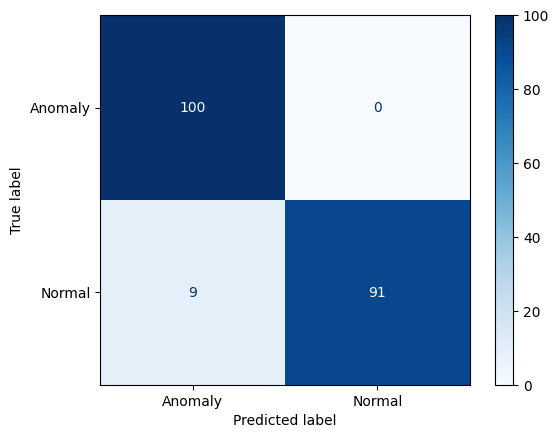

In [ ]:
y_pred_plot = y_pred.copy()
y_pred_plot[y_pred_plot == -1] = 0
y_test_plot = y_test.copy()
y_test_plot[y_test_plot == -1] = 0
cm = metrics.confusion_matrix(y_test_plot, y_pred_plot)
cmd = metrics.ConfusionMatrixDisplay(cm, display_labels=['Anomaly','Normal'])
cmd.plot(cmap=plt.cm.Blues)

# Data - ISCC 2024

## Heatmaps

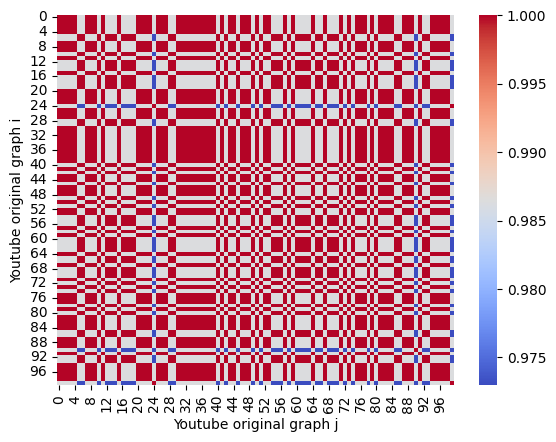

<Figure size 640x480 with 0 Axes>

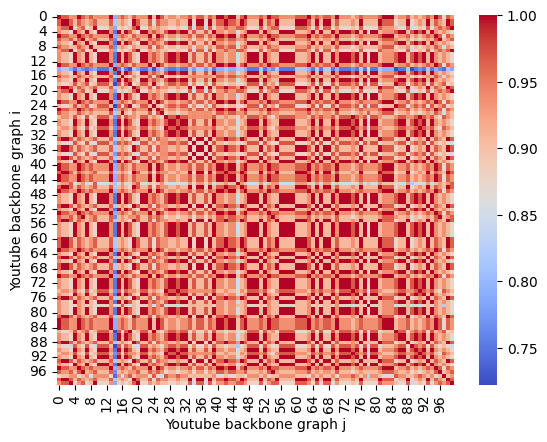

<Figure size 640x480 with 0 Axes>

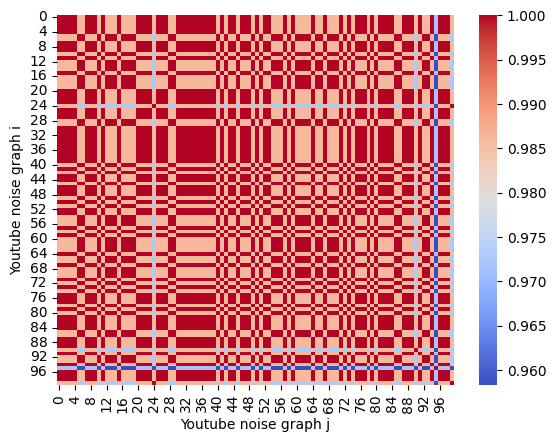

<Figure size 640x480 with 0 Axes>

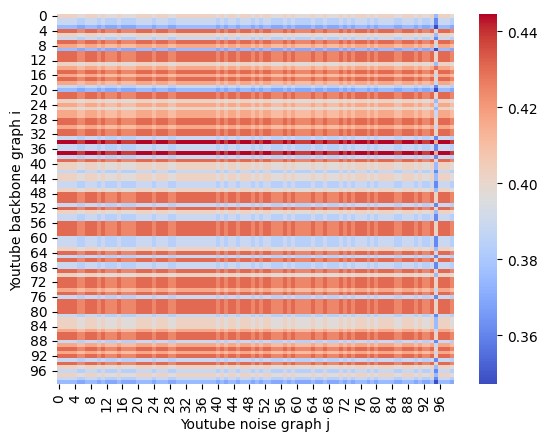

<Figure size 640x480 with 0 Axes>

In [ ]:
for k in range(0,1):
  list_result_base = []
  list_result_filtered = []
  list_result_noise = []
  list_result_filtered_noise = []
  for i in range(100 * k,100 * (k + 1)):
    filename = 'scenario' + str(k) + '_graph' + str(i) + '_consolidated'
    df_i_base = pd.read_csv(CONSOLIDATED + filename)

    filename = 'Backbone_filtered_consolidated' + str(i) + '.edgelist'
    df_i_filtered = pd.read_csv(FILTERED_CONSOLIDATED + filename)

    filename = 'Backbone_noise_consolidated' + str(i) + '.edgelist'
    df_i_noise = pd.read_csv(NOISE_CONSOLIDATED + filename)

    set_task_i_base = set(tuple(zip(df_i_base['src-type'],df_i_base['trg-type'],df_i_base['edge-type'])))
    set_task_i_filtered = set(tuple(zip(df_i_filtered['src-type'],df_i_filtered['trg-type'],df_i_filtered['edge-type'])))
    set_task_i_noise = set(tuple(zip(df_i_noise['src-type'],df_i_noise['trg-type'],df_i_noise['edge-type'])))

    for j in range (100 * k, 100 * (k + 1)):
      filename = 'scenario' + str(k) + '_graph' + str(j) + '_consolidated'
      df_j_base = pd.read_csv(CONSOLIDATED + filename)

      filename = 'Backbone_filtered_consolidated' + str(j) + '.edgelist'
      df_j_filtered = pd.read_csv(FILTERED_CONSOLIDATED + filename)

      filename = 'Backbone_noise_consolidated' + str(j) + '.edgelist'
      df_j_noise = pd.read_csv(NOISE_CONSOLIDATED + filename)

      # As i'm using set inside the tuple, equal edges are not going to appear
      # Since the weight is being counted for each row, it's not expected to have similar edges anyway
      set_task_j_base = set(tuple(zip(df_j_base['src-type'],df_j_base['trg-type'],df_j_base['edge-type'])))
      set_task_j_filtered = set(tuple(zip(df_j_filtered['src-type'],df_j_filtered['trg-type'],df_j_filtered['edge-type'])))
      set_task_j_noise = set(tuple(zip(df_j_noise['src-type'],df_j_noise['trg-type'],df_j_noise['edge-type'])))

      # Computar similaridade sklearn (mais básica, sem intensidade, peso, etc)
      # jaccard
      sim_base = compute_sim(set_task_i_base, set_task_j_base)
      list_result_base.append((i,j,sim_base))

      sim_filtered = compute_sim(set_task_i_filtered, set_task_j_filtered)
      list_result_filtered.append((i,j,sim_filtered))

      sim_noise = compute_sim(set_task_i_noise, set_task_j_noise)
      list_result_noise.append((i,j,sim_noise))

      sim_filtered_noise = compute_sim(set_task_i_filtered, set_task_j_noise)
      list_result_filtered_noise.append((i,j,sim_filtered_noise))



  #df = pd.DataFrame(list_result, columns=['Task1', 'Task2', 'Similarity'])

  matrix_base = np.zeros((100,100))
  matrix_filtered = np.zeros((100,100))
  matrix_noise = np.zeros((100,100))
  matrix_filtered_noise = np.zeros((100,100))
  for simi_base in list_result_base:
    matrix_base[simi_base[0] % 100][simi_base[1] % 100] = simi_base[2]
    #matrix_base[simi_base[1] % 100][simi_base[0] % 100] = simi_base[2]

  for simi_filtered in list_result_filtered:
    matrix_filtered[simi_filtered[0] % 100][simi_filtered[1] % 100] = simi_filtered[2]
    #matrix_filtered[simi_filtered[1] % 100][simi_filtered[0] % 100] = simi_filtered[2]

  for simi_noise in list_result_noise:
    matrix_noise[simi_noise[0] % 100][simi_noise[1] % 100] = simi_noise[2]
    #matrix_noise[simi_noise[1] % 100][simi_noise[0] % 100] = simi_noise[2]

  for simi_filtered_noise in list_result_filtered_noise:
    matrix_filtered_noise[simi_filtered_noise[0] % 100][simi_filtered_noise[1] % 100] = simi_filtered_noise[2]
    #matrix_filtered_noise[simi_filtered_noise[1] % 100][simi_filtered_noise[0] % 100] = simi_filtered_noise[2]

  fig, axs = plt.subplots()
  sns.heatmap(matrix_base, fmt=".2f", cmap="coolwarm", ax = axs)

  #fig.tight_layout()
  axs.set_ylabel('Youtube original graph i')
  axs.set_xlabel('Youtube original graph j')
  fig.show()
  fig.figure.savefig("comparison_base_yt.png")
  plt.figure()

  fig, axs = plt.subplots()
  sns.heatmap(matrix_filtered, fmt=".2f", cmap="coolwarm", ax = axs)

  #fig.tight_layout()
  axs.set_ylabel('Youtube backbone graph i')
  axs.set_xlabel('Youtube backbone graph j')
  fig.show()
  fig.figure.savefig("comparison_filtered_yt.png")
  plt.figure()

  fig, axs = plt.subplots()
  sns.heatmap(matrix_noise, fmt=".2f", cmap="coolwarm", ax = axs)

  #fig.tight_layout()
  axs.set_ylabel('Youtube noise graph i')
  axs.set_xlabel('Youtube noise graph j')
  fig.show()
  fig.figure.savefig("comparison_noise_yt.png")
  plt.figure()

  fig, axs = plt.subplots()
  sns.heatmap(matrix_filtered_noise, fmt=".2f", cmap="coolwarm", ax = axs)

  #fig.tight_layout()
  axs.set_ylabel('Youtube backbone graph i')
  axs.set_xlabel('Youtube noise graph j')
  fig.show()
  fig.figure.savefig("comparison_filtered_noise_yt.png")
  plt.figure()



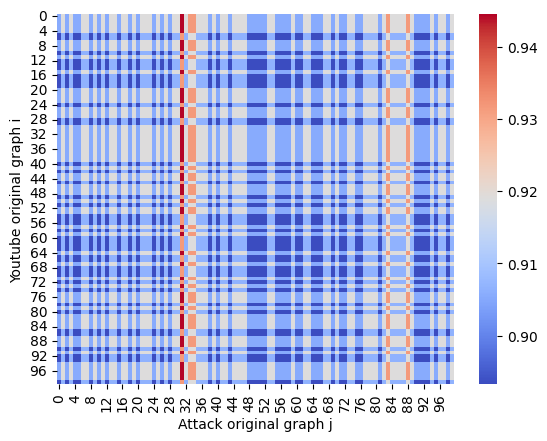

<Figure size 640x480 with 0 Axes>

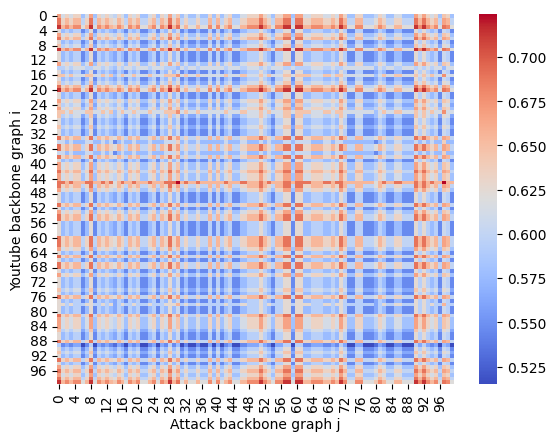

<Figure size 640x480 with 0 Axes>

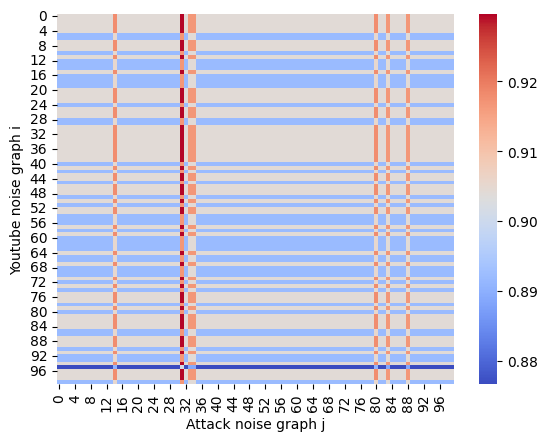

<Figure size 640x480 with 0 Axes>

In [ ]:
for k in range(0,1):
  list_result_base = []
  list_result_filtered = []
  list_result_noise = []
  for i in range(100 * k,100 * (k + 1)):
    filename = 'scenario' + str(k) + '_graph' + str(i) + '_consolidated'
    df_i_base = pd.read_csv(CONSOLIDATED + filename)

    filename = 'Backbone_filtered_consolidated' + str(i) + '.edgelist'
    df_i_filtered = pd.read_csv(FILTERED_CONSOLIDATED + filename)

    filename = 'Backbone_noise_consolidated' + str(i) + '.edgelist'
    df_i_noise = pd.read_csv(NOISE_CONSOLIDATED + filename)

    set_task_i_base = set(tuple(zip(df_i_base['src-type'],df_i_base['trg-type'],df_i_base['edge-type'])))
    set_task_i_filtered = set(tuple(zip(df_i_filtered['src-type'],df_i_filtered['trg-type'],df_i_filtered['edge-type'])))
    set_task_i_noise = set(tuple(zip(df_i_noise['src-type'],df_i_noise['trg-type'],df_i_noise['edge-type'])))
    for j in range (300, 400):
      filename = 'scenario3' + '_graph' + str(j) + '_consolidated'
      df_j_base = pd.read_csv(CONSOLIDATED + filename)

      filename = 'Backbone_filtered_consolidated' + str(j) + '.edgelist'
      df_j_filtered = pd.read_csv(FILTERED_CONSOLIDATED + filename)

      filename = 'Backbone_noise_consolidated' + str(j) + '.edgelist'
      df_j_noise = pd.read_csv(NOISE_CONSOLIDATED + filename)

      # As i'm using set inside the tuple, equal edges are not going to appear
      # Since the weight is being counted for each row, it's not expected to have similar edges anyway
      set_task_j_base = set(tuple(zip(df_j_base['src-type'],df_j_base['trg-type'],df_j_base['edge-type'])))
      set_task_j_filtered = set(tuple(zip(df_j_filtered['src-type'],df_j_filtered['trg-type'],df_j_filtered['edge-type'])))
      set_task_j_noise = set(tuple(zip(df_j_noise['src-type'],df_j_noise['trg-type'],df_j_noise['edge-type'])))

      # Computar similaridade sklearn (mais básica, sem intensidade, peso, etc)
      # jaccard
      sim_base = compute_sim(set_task_i_base, set_task_j_base)
      list_result_base.append((i,j,sim_base))

      sim_filtered = compute_sim(set_task_i_filtered, set_task_j_filtered)
      list_result_filtered.append((i,j,sim_filtered))

      sim_noise = compute_sim(set_task_i_noise, set_task_j_noise)
      list_result_noise.append((i,j,sim_noise))


  #df = pd.DataFrame(list_result, columns=['Task1', 'Task2', 'Similarity'])

  matrix_base = np.zeros((100,100))
  matrix_filtered = np.zeros((100,100))
  matrix_noise = np.zeros((100,100))
  for simi_base in list_result_base:
    matrix_base[simi_base[0] % 100][simi_base[1] % 100] = simi_base[2]
    #matrix_base[simi_base[1] % 100][simi_base[0] % 100] = simi_base[2]

  for simi_filtered in list_result_filtered:
    matrix_filtered[simi_filtered[0] % 100][simi_filtered[1] % 100] = simi_filtered[2]
    #matrix_filtered[simi_filtered[1] % 100][simi_filtered[0] % 100] = simi_filtered[2]

  for simi_noise in list_result_noise:
    matrix_noise[simi_noise[0] % 100][simi_noise[1] % 100] = simi_noise[2]
    #matrix_noise[simi_noise[1] % 100][simi_noise[0] % 100] = simi_noise[2]

  fig, axs = plt.subplots()
  sns.heatmap(matrix_base, fmt=".2f", cmap="coolwarm", ax = axs)
  axs.set_ylabel('Youtube original graph i')
  axs.set_xlabel('Attack original graph j')
  fig.show()
  fig.figure.savefig("comparison_base_yt_atk.png")
  plt.figure()

  fig, axs = plt.subplots()
  sns.heatmap(matrix_filtered, fmt=".2f", cmap="coolwarm", ax = axs)
  axs.set_ylabel('Youtube backbone graph i')
  axs.set_xlabel('Attack backbone graph j')
  fig.show()
  fig.figure.savefig("comparison_filtered_yt_atk.png")
  plt.figure()

  fig, axs = plt.subplots()
  sns.heatmap(matrix_noise, fmt=".2f", cmap="coolwarm", ax = axs)
  axs.set_ylabel('Youtube noise graph i')
  axs.set_xlabel('Attack noise graph j')
  fig.show()
  fig.figure.savefig("comparison_noise_yt_atk.png")
  plt.figure()


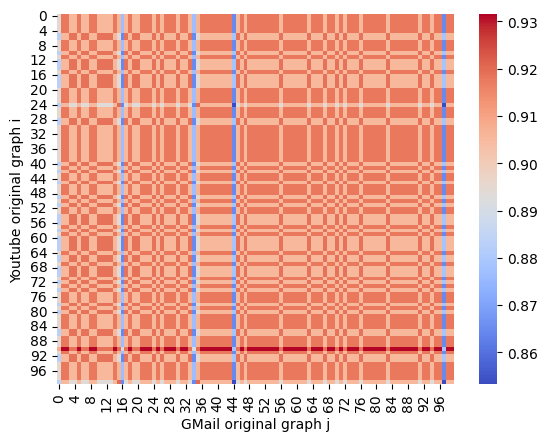

<Figure size 640x480 with 0 Axes>

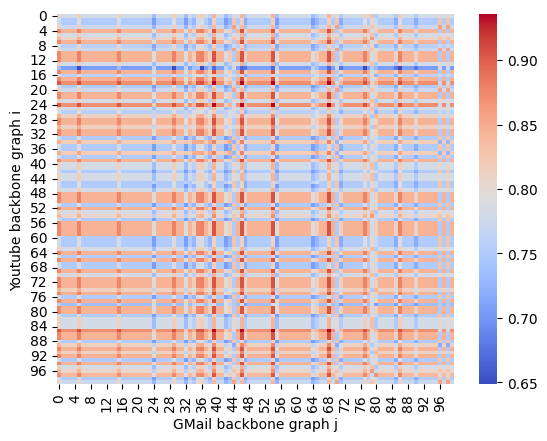

<Figure size 640x480 with 0 Axes>

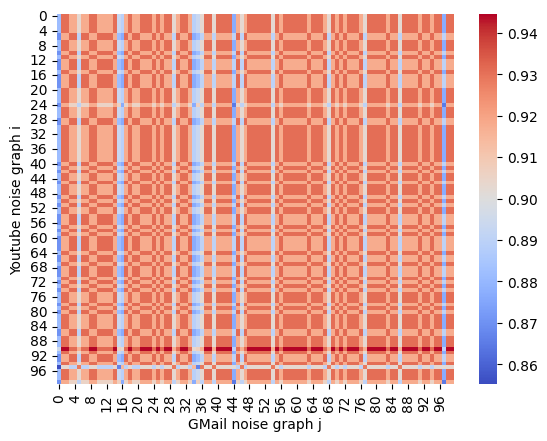

<Figure size 640x480 with 0 Axes>

In [ ]:
for k in range(0,1):
  list_result_base = []
  list_result_filtered = []
  list_result_noise = []
  for i in range(100 * k,100 * (k + 1)):
    filename = 'scenario' + str(k) + '_graph' + str(i) + '_consolidated'
    df_i_base = pd.read_csv(CONSOLIDATED + filename)

    filename = 'Backbone_filtered_consolidated' + str(i) + '.edgelist'
    df_i_filtered = pd.read_csv(FILTERED_CONSOLIDATED + filename)

    filename = 'Backbone_noise_consolidated' + str(i) + '.edgelist'
    df_i_noise = pd.read_csv(NOISE_CONSOLIDATED + filename)

    set_task_i_base = set(tuple(zip(df_i_base['src-type'],df_i_base['trg-type'],df_i_base['edge-type'])))
    set_task_i_filtered = set(tuple(zip(df_i_filtered['src-type'],df_i_filtered['trg-type'],df_i_filtered['edge-type'])))
    set_task_i_noise = set(tuple(zip(df_i_noise['src-type'],df_i_noise['trg-type'],df_i_noise['edge-type'])))
    for j in range (100, 200):
      filename = 'scenario1' + '_graph' + str(j) + '_consolidated'
      df_j_base = pd.read_csv(CONSOLIDATED + filename)

      filename = 'Backbone_filtered_consolidated' + str(j) + '.edgelist'
      df_j_filtered = pd.read_csv(FILTERED_CONSOLIDATED + filename)

      filename = 'Backbone_noise_consolidated' + str(j) + '.edgelist'
      df_j_noise = pd.read_csv(NOISE_CONSOLIDATED + filename)

      # As i'm using set inside the tuple, equal edges are not going to appear
      # Since the weight is being counted for each row, it's not expected to have similar edges anyway
      set_task_j_base = set(tuple(zip(df_j_base['src-type'],df_j_base['trg-type'],df_j_base['edge-type'])))
      set_task_j_filtered = set(tuple(zip(df_j_filtered['src-type'],df_j_filtered['trg-type'],df_j_filtered['edge-type'])))
      set_task_j_noise = set(tuple(zip(df_j_noise['src-type'],df_j_noise['trg-type'],df_j_noise['edge-type'])))

      # Computar similaridade sklearn (mais básica, sem intensidade, peso, etc)
      # jaccard
      sim_base = compute_sim(set_task_i_base, set_task_j_base)
      list_result_base.append((i,j,sim_base))

      sim_filtered = compute_sim(set_task_i_filtered, set_task_j_filtered)
      list_result_filtered.append((i,j,sim_filtered))

      sim_noise = compute_sim(set_task_i_noise, set_task_j_noise)
      list_result_noise.append((i,j,sim_noise))


  #df = pd.DataFrame(list_result, columns=['Task1', 'Task2', 'Similarity'])

  matrix_base = np.zeros((100,100))
  matrix_filtered = np.zeros((100,100))
  matrix_noise = np.zeros((100,100))
  for simi_base in list_result_base:
    matrix_base[simi_base[0] % 100][simi_base[1] % 100] = simi_base[2]
    #matrix_base[simi_base[1] % 100][simi_base[0] % 100] = simi_base[2]

  for simi_filtered in list_result_filtered:
    matrix_filtered[simi_filtered[0] % 100][simi_filtered[1] % 100] = simi_filtered[2]
    #matrix_filtered[simi_filtered[1] % 100][simi_filtered[0] % 100] = simi_filtered[2]

  for simi_noise in list_result_noise:
    matrix_noise[simi_noise[0] % 100][simi_noise[1] % 100] = simi_noise[2]
    #matrix_noise[simi_noise[1] % 100][simi_noise[0] % 100] = simi_noise[2]

  fig, axs = plt.subplots()
  sns.heatmap(matrix_base, fmt=".2f", cmap="coolwarm", ax = axs)
  axs.set_ylabel('Youtube original graph i')
  axs.set_xlabel('GMail original graph j')
  fig.show()
  fig.figure.savefig("comparison_base_yt_gmail.png")
  plt.figure()

  fig, axs = plt.subplots()
  sns.heatmap(matrix_filtered, fmt=".2f", cmap="coolwarm", ax = axs)
  axs.set_ylabel('Youtube backbone graph i')
  axs.set_xlabel('GMail backbone graph j')
  fig.show()
  fig.figure.savefig("comparison_filtered_yt_gmail.png")
  plt.figure()

  fig, axs = plt.subplots()
  sns.heatmap(matrix_noise, fmt=".2f", cmap="coolwarm", ax = axs)
  axs.set_ylabel('Youtube noise graph i')
  axs.set_xlabel('GMail noise graph j')
  fig.show()
  fig.figure.savefig("comparison_noise_yt_gmail.png")
  plt.figure()
